### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday, October 15th at 17:00.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


/home/marvin/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/marvin/miniconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
def binarize(X):
    # YOUR CODE HERE
    X = np.where(X < 128, 0.0, 1.0)
    
    return X

In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

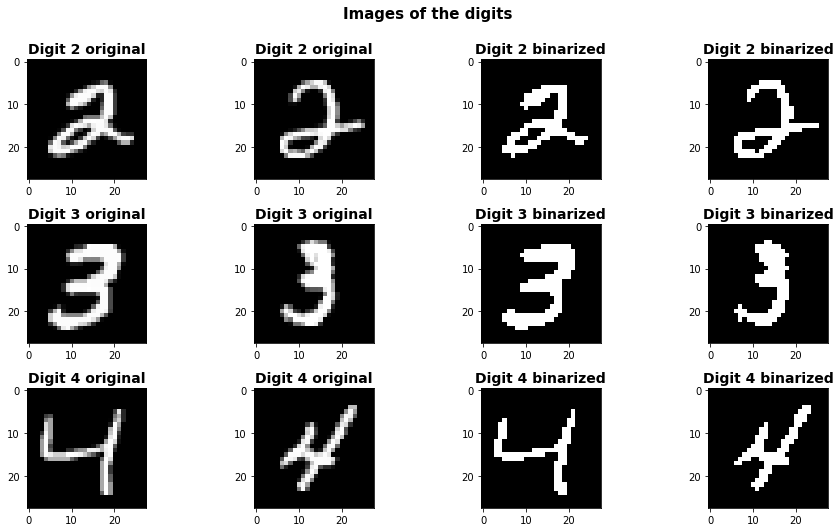

In [4]:
# YOUR CODE HERE

indices_2 = np.where(train_labels == 2)[0]
indices_3 = np.where(train_labels == 3)[0]
indices_4 = np.where(train_labels == 4)[0]

fig = plt.figure(figsize=(13,7))
fig.suptitle("Images of the digits", fontweight="bold",fontsize=15,y=1.05)
    
for i,indices in enumerate([indices_2,indices_3,indices_4]):
    
    first_in = indices[0]
    second_in = indices[1]
    
    original_first = train_data[first_in]
    original_second = train_data[second_in]
    
    binary_first = bin_train_data[first_in]
    binary_second = bin_train_data[second_in]
    
    for j,data in enumerate([original_first,original_second,binary_first,binary_second]):
        ax = plt.subplot(3,4,i*4 + j+1)
        plt.imshow(data.reshape(28,28),cmap='gray')
        title = "Digit " + str(i+2)
        if j < 2:
            title += " original"
        else:
            title += " binarized"
    
        plt.title(title,fontweight="bold",fontsize=14)
        
plt.tight_layout()
plt.show()

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$

In [5]:
def E_step(X, mu, pi):
    # YOUR CODE HERE
    #X is N,D
    #Mu is K,D
    #Pi is K,
    
    N = X.shape[0]
    K = pi.shape[0]
    gamma = np.zeros((N,K))
    
    for k in range(K):
        pi_k = pi[k]
        mu_k = mu[k,:]
        first_term = mu_k**X
        second_term = (1 - mu_k)**(1-X)
        bernoulli = np.prod( np.multiply(first_term,second_term),axis=1)
        gamma_k = pi_k * bernoulli
        
        gamma[:,k] = gamma_k
    
    normalizer = np.sum(gamma,axis=1)
    gamma = gamma / normalizer.reshape(-1,1)
    
    return gamma

In [6]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [7]:
def M_step(X, gamma):
    # YOUR CODE HERE
    N,K = gamma.shape
    D = X.shape[1]
    
    mu = np.zeros((K,D))
    
    N_ks = np.sum(gamma,axis=0)
    pi = N_ks / N
    
    for k in range(K):
        gamma_k = gamma[:,k]
        mu_k = np.sum(gamma_k.reshape(-1,1) * X,axis=0) / N_ks[k]
        mu[k,:] = mu_k

    return mu, pi

In [8]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [9]:
def EM(X, K, max_iter, mu=None, pi=None):
    # YOUR CODE HERE
    N,D = X.shape
    threshold = 0.0005
    
    if mu is None:
        mu = np.random.uniform(low=.25, high=.75, size=(K,D))
    
    if pi is None:
        pi = np.ones(K) / K
    
    for i in range(max_iter):
        old_mu = mu
        old_pi = pi
        
        gamma = E_step(X, mu, pi)
        mu, pi = M_step(X, gamma)
        
        mu_converged = np.linalg.norm(mu-old_mu) < threshold 
        pi_converged = np.linalg.norm(pi-old_pi) < threshold 

        if mu_converged and pi_converged:
            print("Converged at step ",i+1)
            break
    
    return mu,pi,gamma

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

Converged at step  15


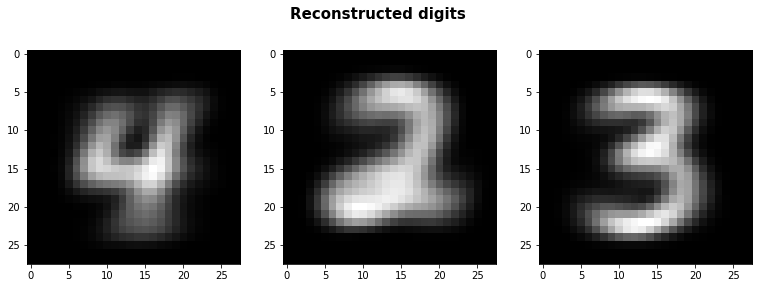

In [10]:
# YOUR CODE HERE

indices_2 = np.where(train_labels == 2)[0]
indices_3 = np.where(train_labels == 3)[0]
indices_4 = np.where(train_labels == 4)[0]

all_2 = bin_train_data[indices_2]
all_3 = bin_train_data[indices_3]
all_4 = bin_train_data[indices_4]

subset = np.concatenate((all_2, all_3,all_4), axis=0) 

em_mu3,em_pi3,em_gamma3 = EM(subset,3,75)

fig = plt.figure(figsize=(13,7))
fig.suptitle("Reconstructed digits", fontweight="bold",fontsize=15,y=0.8)

for i,mu in enumerate(em_mu3):
    plt.subplot(1,3,i+1)
    plt.imshow(mu.reshape(28,28),cmap='gray')

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

In [11]:
print("Returned Pi : ", em_pi3)
total = subset.shape[0]
print("True proportion of digits 4 in subset: " ,len(indices_4)/total)
print("True proportion of digits 2 in subset: " ,len(indices_2)/total)
print("True proportion of digits 3 in subset: " ,len(indices_3)/total)


Returned Pi :  [0.34751031 0.31859166 0.33389804]
True proportion of digits 4 in subset:  0.32580447270090906
True proportion of digits 2 in subset:  0.33227371591099214
True proportion of digits 3 in subset:  0.34192181138809885


From the plotted images above, we can observe which class belongs to which digit. In the time of writing this, the first class is the digit 4, the second class is digit 2 and the third class is digit 3. The mixture componens are quite similiar to the true proportions of the training data. Maybe a difference of plus minus 0.02. All values of converged mixture components and the true proportions are in the range of 0.31 to 0.34 for each class. So the mixtures seems to be uniformly distributed

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

Converged at step  2


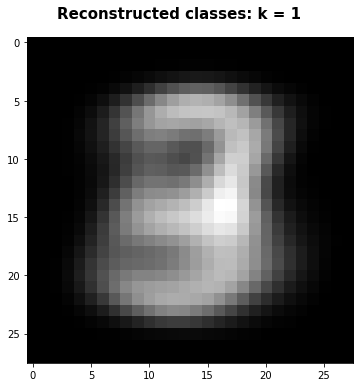

Converged at step  54


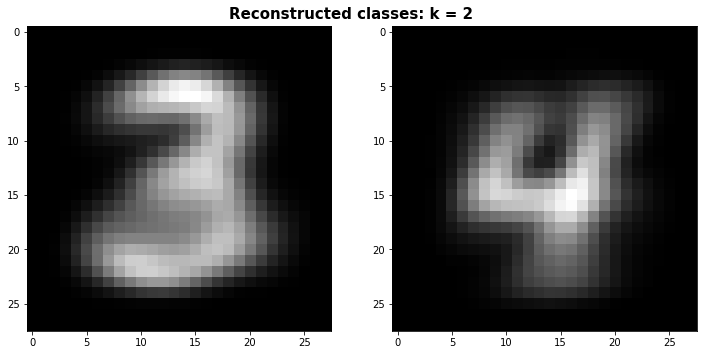

Converged at step  22


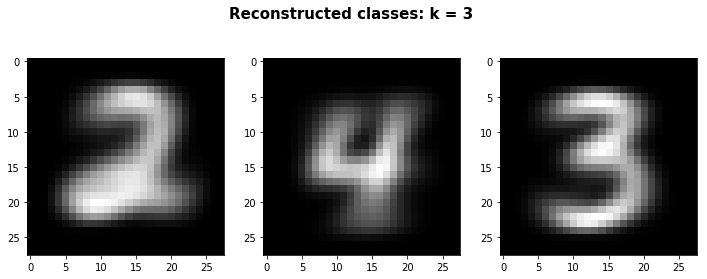

Converged at step  66


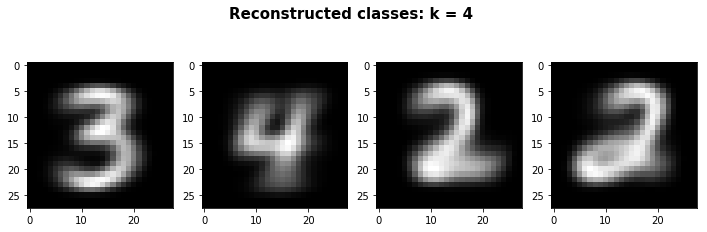

Converged at step  59


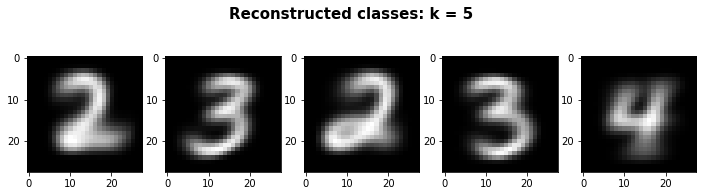

In [12]:
# YOUR CODE HERE
for k in [1,2,3,4,5]:
    em_mu,em_pi,em_gamma = EM(subset,k,75)

    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Reconstructed classes: k = " + str(k), fontweight="bold",fontsize=15,y= 1.0 - k * (0.15/3))

    for i,mu in enumerate(em_mu):
        plt.subplot(1,k,i+1)
        plt.imshow(mu.reshape(28,28),cmap='gray')
    plt.show()

With a smaller latent space than actual class size, we still get a decent image of a digit, it is only a bit more blurry. Probably due to the fact that also some other digits are mixed in the cluster as there is only 1 or two classes. It can also be observed that mainly the digit 3 is reconstructed, meaning that it probably is easier to cluster to compared to the other digits. Followed by the digit 4. 

When the latent space size is greater than the actual class size, we get more clearer images again. The difference now is that there are duplicates of digits and the duplicate is a different variant of the digit. For example, when latent space is 5, it was observed that there are 3 normal and straight digits of 2,3 and 4. While there were also a duplicate digit of 4 that was more tilted to the right and a variant of the digit 2 which was more with a curly style of writing. 

It was also observed that when k = 1, it converged very fast, which is logical if there is only 1 cluster, and takes longer with any number of classes that is not equal to the true amount of classes. 

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

Amount of assignments:  {2: 4036, 3: 6632, 4: 7263}
Amount misclassified:  2770


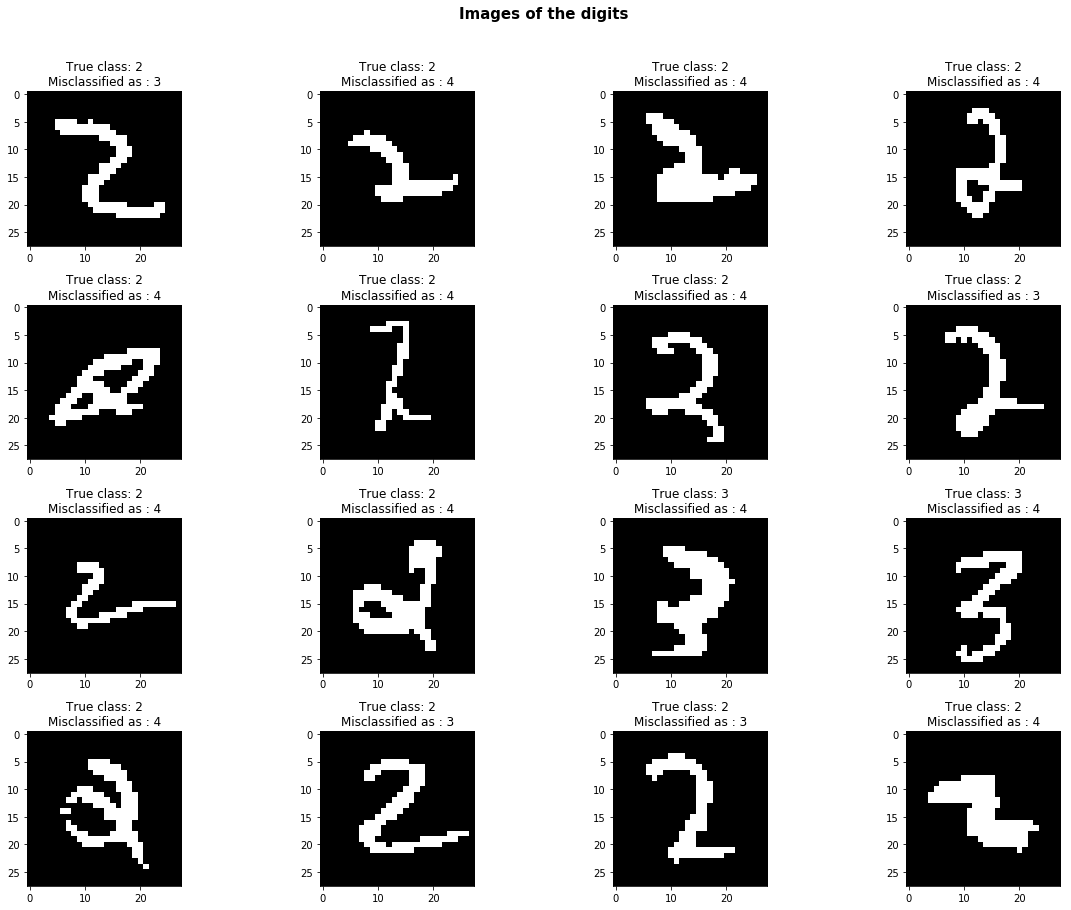

In [13]:
# YOUR CODE HERE
#Getting the labels
all_2_labels = train_labels[indices_2]
all_3_labels = train_labels[indices_3]
all_4_labels = train_labels[indices_4]

subset_labels = np.concatenate((all_2_labels, all_3_labels,all_4_labels), axis=0) 

N,D = subset.shape
K,D = em_mu3.shape

def plot_missclassifications(N,K,D,em_mu):
    #We can measure the distance of data point and the each cluster to find the closest one as assignment
    diffs = np.zeros((N,K))
    for k in range(K):
        diff_k = np.sum( np.abs(subset - em_mu[k,:]),axis = 1)
        diffs[:,k] = diff_k

    assignments = np.argmin(diffs,axis=1) 

    # We can see from above that the class correspond to digit 4,2 and 3, so we replace the values:
    assignments = np.where(assignments==0, 4, assignments)
    assignments = np.where(assignments==2, 3, assignments)
    assignments = np.where(assignments==1, 2, assignments)
    unique, counts = numpy.unique(assignments, return_counts=True)
    print("Amount of assignments: ", dict(zip(unique, counts)))

    #Find misclassifications
    correct = assignments == subset_labels
    print("Amount misclassified: ", (len(subset) - sum(correct)))
    missclassified_idx = np.where(correct == False)[0]
    samples = np.random.choice(missclassified_idx,16)

    #Plot
    fig = plt.figure(figsize=(17,12))
    fig.suptitle("Images of the digits", fontweight="bold",fontsize=15,y=1.05)
    for i,idx in enumerate(samples):
        plt.subplot(4,4,i+1)
        img = subset[idx]
        plt.title("True class: "+ str(subset_labels[idx]) + "\nMisclassified as : " + str(assignments[idx]))
        plt.imshow(img.reshape(28,28),cmap='gray')

    plt.tight_layout()
    plt.show()
    
plot_missclassifications(N,K,D,em_mu3)

First we can try to find the assignment of each data point to a cluster by taking the absolute difference and summing over the dimension. Then we want to find the cluster closest to the datapoint, so we take the argmin. The argmin correspond to the classes of the weights we found. We visualized those $\mu$ before and know the digits 4,2,3 are for index 0,1,2 respectively. Thus we use that mapping as assignment and compare that to each label to look for misclassifications.

From those plotted misclassifications. It can be observed that there are some weird shapes of numbers that are hard to classify, as they hardly represent a digit. This can be stretched,curly and tilted digits. It can also be observed that mainly 2s and 3s are misclassified judging from this sample batch. Which makes sense as 2 has the lowest amount of assignments, below the total amount for each class. The digit 2 and 3 also has some similiar features, one could see for example that a 2 is a 3 but missing the bottom half. The digit 4 on the other hand has more distinct features such as vertical lines instead of the horizontal lines shared by digit 2 and 3. 

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

Converged at step  12
Amount of assignments:  {2: 4036, 3: 6632, 4: 7263}
Amount misclassified:  2770


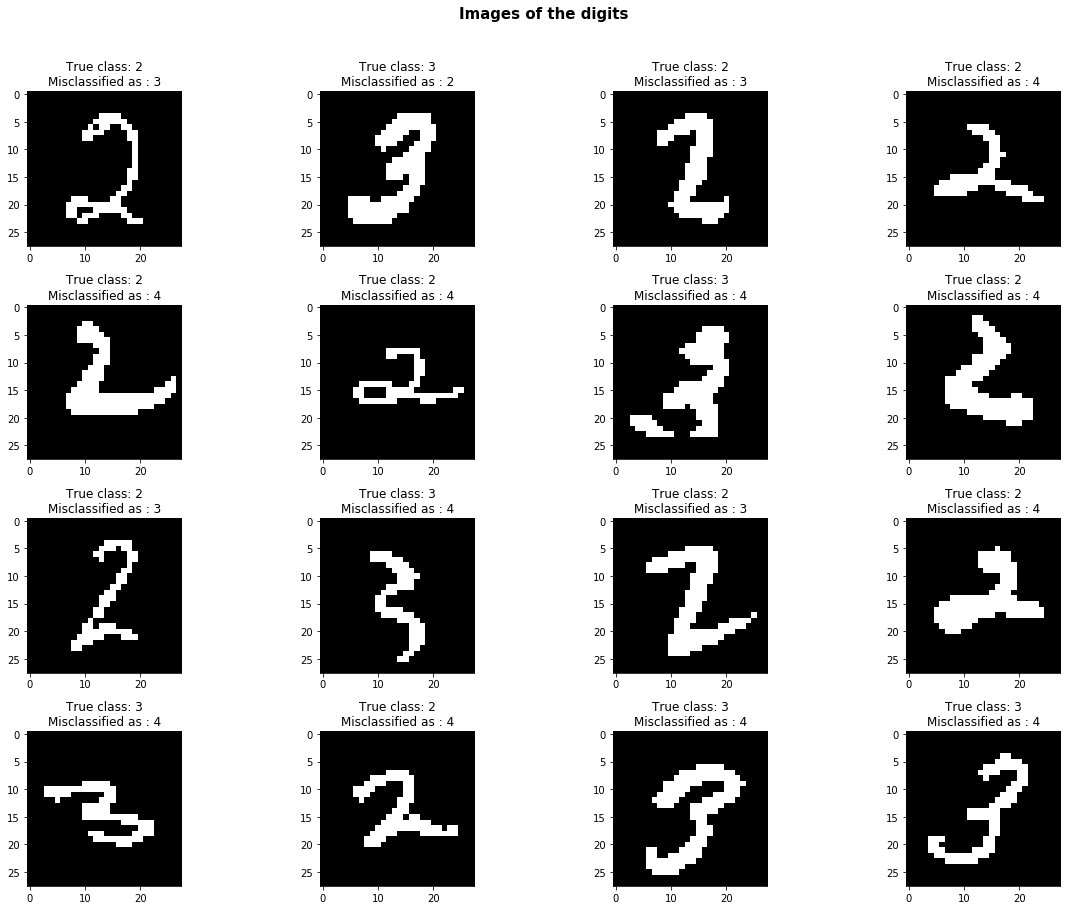

In [14]:
# YOUR CODE HERE
pi_4 = len(indices_4)/total
pi_2 = len(indices_2)/total
pi_3 = len(indices_3)/total

pi_calc = np.array([pi_4,pi_2,pi_3])

mu_4 = np.mean(all_4,axis=0)
mu_2 = np.mean(all_2,axis=0)
mu_3 = np.mean(all_3,axis=0)

mu_calc = np.array([mu_4,mu_2,mu_3])

em_mu,em_pi,em_gamma = EM(subset,3,75,mu_calc,pi_calc)

plot_missclassifications(N,K,D,em_mu3)


We see that the amount of misclassifications has dropped with 30 samples, so not a huge difference. The distributions of assignments seems similiar. The plotted misclassifcations are similiar as before 

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [15]:
def log_bernoulli_loss(x_hat, x):
    
    # YOUR CODE HERE
    #Add some small value to denominator of log to avoid instability of inf
    loss = -1 * (x * torch.log(x_hat +  0.00000001) + (1 - x) * torch.log(1 - x_hat +  0.00000001))
    loss = torch.sum(loss,dim=1) #Sum over the dimensions
    loss = torch.sum(loss) #sum the loss of the batches to pass the assertion
    
    return loss

In [16]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!


Source: https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

We can follow the same approach as in homework 2 and various sources to compute the KL divergence between 2 gaussians as follows:

$$
D_{KL}(q(z)||p(z)) = - \int q(z) \ ln \frac{p(z)}{q(z)} dz
$$

$$
= - \int q(z) \ ln (p(z)- q(z)) \ dz
$$

$$
 \ \frac{1}{2} \int \{ - ln \ \frac{|\sigma^2 I|}{|I|} + (z - 0)^T I (z-0) - (z-\mu)^T (\sigma^2 I)^{-1}(z-\mu) \} \  q(z) \ dz
$$

$$
 \ \frac{1}{2} \{ - ln \ |\sigma^2| +  E[(z - 0)^T I (z-0)]_{q(z)} - E[(z-\mu)^T (\sigma^2 I)^{-1}(z-\mu)]_{q(z)}  \}
$$

$$
 \ \frac{1}{2} \{ - ln \ |\sigma^2| +  (\mu - 0)^T I (\mu-0) + Tr({I}^{-1} \ \sigma^2 I) - Tr((\sigma^2 I)^{-1} \sigma^2 I) \ \}
$$

$$
 \ \frac{1}{2} \{ - ln \ |\sigma^2| +  \mu^2 + Tr(\sigma^2) - D \ \}
$$

We can sum over D dimension to simplify it and get rid of the determinant and the trace:

$$
 \ \frac{1}{2} \{ - ln \prod_D \ \sigma^2 +  \sum_D \mu^2 + \sum_D \sigma^2 - \sum_D 1 \ \}
$$


$$
 \ \frac{1}{2} \{ - \sum_D ln \ \sigma^2 +  \sum_D \mu^2 + \sum_D \sigma^2 - \sum_D 1 \ \}
$$
$$
 \ \frac{1}{2}  \sum_D  \{ - ln \ \sigma^2 +  \mu^2 + \sigma^2 - 1 \ \}
$$

In practice $\sigma^2$ is better treates as the exponent of the log of that to make it more numerically stable, thus we get:
$$
 \ \frac{1}{2}  \sum_D  \{ - ln \ \sigma^2 +  \mu^2 + exp(\ log (\sigma^2)) - 1 \ \}
$$

And since we wanted the negative KL divergence instead of the positive:

$$
- D_{KL}(q(z)||p(z)) =  - \ \frac{1}{2}  \sum_D  \{ ln \ \sigma^2 -  \mu^2 - exp(\ log (\sigma^2)) + 1 \ \}
$$

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [17]:
def KL_loss(mu, logvar):
    
    # YOUR CODE HERE
    inside_term = logvar - mu**2 - torch.exp(logvar) + 1
    loss = -0.5 * torch.sum(inside_term)
    
    return loss


In [18]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [19]:
def loss_function(x_hat, x, mu, logvar):
    
    # YOUR CODE HERE
    loss = log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)
    return loss


In [20]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [21]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [22]:
def encode(self, x):
    
    # YOUR CODE HERE
    shared_embed_x = self.fc1(x)
    
    #Use a ReLU layer and Adam to speed up convergence as stated in Carl Doersh's Tutorial of VAEs
    shared_embed_x = F.relu(shared_embed_x)
    
    mu = self.fc21(shared_embed_x)  
    logvar = self.fc22(shared_embed_x)  
    
    #Make std/var should be positive (and gives stability)
    #var = F.relu(var)
    #logvar = torch.log(var)
    
    return mu, logvar


In [23]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [24]:
def reparameterize(self, mu, logvar):
            
        # YOUR CODE HERE
        
        epsilon = torch.randn(mu.shape)
        z = mu + logvar * epsilon 
        
        return z


In [25]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [26]:
def decode(self, z):
    
    # YOUR CODE HERE
    output = self.fc3(z)
    output = F.relu(output)
    mean = self.fc4(output)

    #Constrain values to 0 and 1 for the parameter of Bernoulli
    x_hat = torch.sigmoid(mean)
    
    return x_hat


In [27]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [28]:
def forward(self, x):
    x = x.view(-1, 784)
    
    # YOUR CODE HERE
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu,logvar)
    x_hat = self.decode(z)
    
    return x_hat, mu, logvar


In [29]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [30]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [31]:
# Hyperparameters
# fc1_dims = (?,?)
# fc21_dims =
# fc22_dims =
# fc3_dims =
# fc4_dims =
# lr =
# batch_size =
# epochs =

# YOUR CODE HERE
input_dim = 784
hidden_dim = 500
z_dim = 20

fc1_dims = (input_dim,hidden_dim)
fc21_dims = (hidden_dim,z_dim)
fc22_dims = (hidden_dim,z_dim)
fc3_dims = (z_dim,hidden_dim)
fc4_dims = (hidden_dim,input_dim)
lr = lr=0.005
batch_size = 100
epochs = 11


In [32]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [33]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 545.152283
Train Epoch: 1 [10000/60000 (17%)]	Loss: 120.579834
Train Epoch: 1 [20000/60000 (33%)]	Loss: 100.631279
Train Epoch: 1 [30000/60000 (50%)]	Loss: 93.021797
Train Epoch: 1 [40000/60000 (67%)]	Loss: 91.220749
Train Epoch: 1 [50000/60000 (83%)]	Loss: 79.817322
====> Epoch: 1 Average loss: 106.3164
Train Epoch: 2 [0/60000 (0%)]	Loss: 81.909874
Train Epoch: 2 [10000/60000 (17%)]	Loss: 78.858025
Train Epoch: 2 [20000/60000 (33%)]	Loss: 83.516632
Train Epoch: 2 [30000/60000 (50%)]	Loss: 79.824150
Train Epoch: 2 [40000/60000 (67%)]	Loss: 86.016647
Train Epoch: 2 [50000/60000 (83%)]	Loss: 80.586334
====> Epoch: 2 Average loss: 80.8196
Train Epoch: 3 [0/60000 (0%)]	Loss: 77.070488
Train Epoch: 3 [10000/60000 (17%)]	Loss: 81.706818
Train Epoch: 3 [20000/60000 (33%)]	Loss: 76.714714
Train Epoch: 3 [30000/60000 (50%)]	Loss: 73.194344
Train Epoch: 3 [40000/60000 (67%)]	Loss: 78.364090
Train Epoch: 3 [50000/60000 (83%)]	Loss: 78.545326
====> Epoch: 3 Aver

Run the box below to check if the model you trained above is able to correctly reconstruct images.

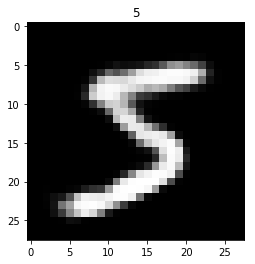

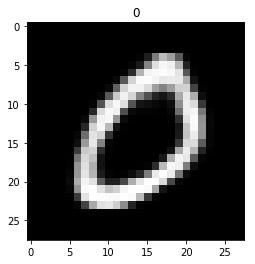

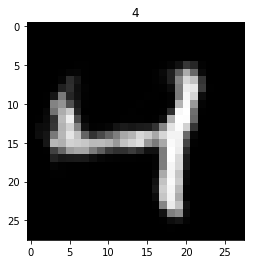

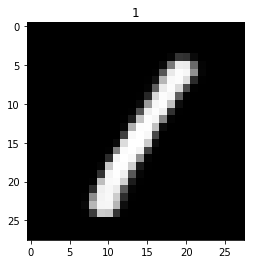

In [34]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [35]:
# YOUR CODE HERE
from torchvision.utils import make_grid
from torchvision.utils import save_image
from scipy.stats import norm
import itertools

input_dim = 784
hidden_dim = 500
z_dim = 2

fc1_dims = (input_dim,hidden_dim)
fc21_dims = (hidden_dim,z_dim)
fc22_dims = (hidden_dim,z_dim)
fc3_dims = (z_dim,hidden_dim)
fc4_dims = (hidden_dim,input_dim)
lr = lr=0.005
batch_size = 100
epochs = 11

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 547.900452
Train Epoch: 1 [10000/60000 (17%)]	Loss: 165.939926
Train Epoch: 1 [20000/60000 (33%)]	Loss: 162.858444
Train Epoch: 1 [30000/60000 (50%)]	Loss: 167.165710
Train Epoch: 1 [40000/60000 (67%)]	Loss: 163.679947
Train Epoch: 1 [50000/60000 (83%)]	Loss: 159.838333
====> Epoch: 1 Average loss: 165.2283
Train Epoch: 2 [0/60000 (0%)]	Loss: 145.771149
Train Epoch: 2 [10000/60000 (17%)]	Loss: 158.119095
Train Epoch: 2 [20000/60000 (33%)]	Loss: 152.522446
Train Epoch: 2 [30000/60000 (50%)]	Loss: 158.058746
Train Epoch: 2 [40000/60000 (67%)]	Loss: 154.174591
Train Epoch: 2 [50000/60000 (83%)]	Loss: 148.700500
====> Epoch: 2 Average loss: 154.1526
Train Epoch: 3 [0/60000 (0%)]	Loss: 153.243774
Train Epoch: 3 [10000/60000 (17%)]	Loss: 150.978348
Train Epoch: 3 [20000/60000 (33%)]	Loss: 144.273102
Train Epoch: 3 [30000/60000 (50%)]	Loss: 156.865112
Train Epoch: 3 [40000/60000 (67%)]	Loss: 152.701859
Train Epoch: 3 [50000/60000 (83%)]	Loss: 155.990906
===

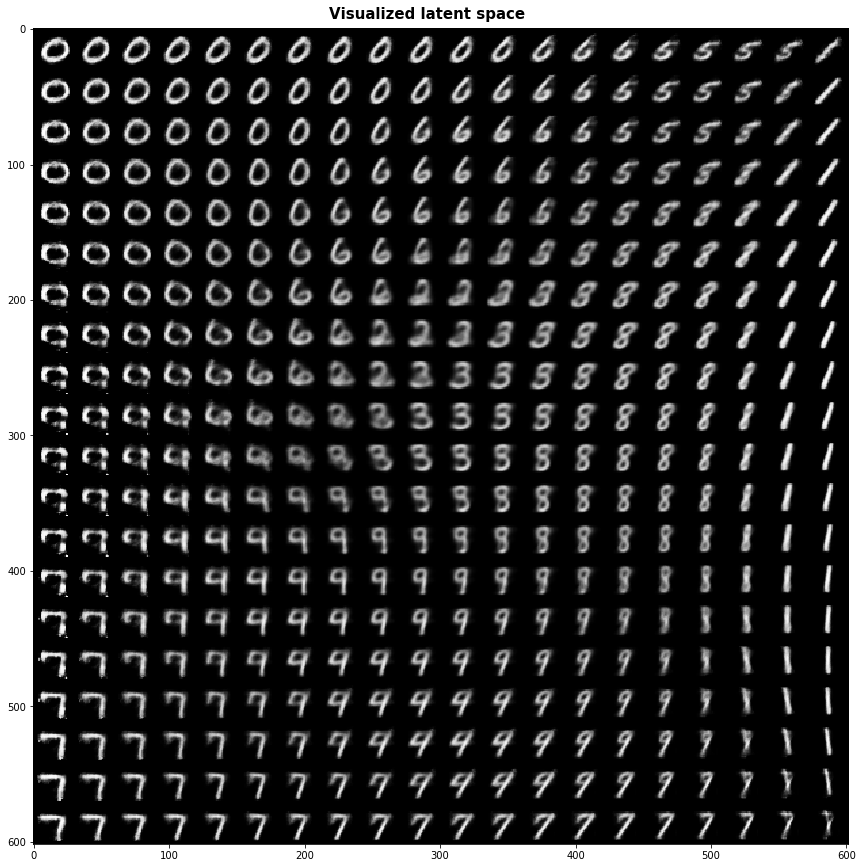

In [36]:

def plot_manifold(x_y_image_dim, manifold_size,model):

    grid = np.linspace(0.05, 0.95, manifold_size)
    grid = list(map(norm.ppf,grid))
    z = torch.tensor(list(itertools.product(grid,grid)) )
    output = model.decode(z)

    output = output.view(-1,1,x_y_image_dim,x_y_image_dim)
    manifold = make_grid(output,manifold_size)

    manifold = manifold.detach().numpy()
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Visualized latent space", fontweight="bold",fontsize=15,y=0.90)
    plt.imshow(np.transpose(manifold, (1,2,0)))
    
# size by size for manifold
manifold_size = 20
x_and_y_dim = int(math.sqrt(input_dim))

plot_manifold(x_and_y_dim,manifold_size,VAE_MNIST)

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


The variational distribution only depends on the data indirectly via the minimization of the KL divergence between q and p. But we want this approximation of the posterior to be true posterior for the whole dataset, which is hard to optimize with different weights in neural network for each data point. We dont want returns of latent activations for a specific input, but want to approximate the true posterior with unknown weights with an model with latent parameters to be able to inference.  

So to solve this, we can use the neural network to predict parameters (of a distribution) instead , then we can share weights between individual data points and optimize better. So in our case we amortize z with inputs of parameters instead of directly having that as output of the encoder network.

In other words as quoted from internet: "We introduce a parameterized function that maps from observation space to the parameters of the approximate posterior distribution" and "now there is an additional constraint imposed by network having to be able to map to all these parameters. Within a specific parametric family, nothing is more general than freely optimizing all the parameters. This cost is known as the amortization gap". 

Source: https://www.quora.com/What-is-amortized-variational-inference